# Kaggle Playground Series 2024: Abalone Age Prediction

## Introduction

Welcome to the **2024 Kaggle Playground Series**! In this competition, we continue the tradition of providing interesting and approachable datasets for our community to hone their machine learning skills. Each month, we anticipate hosting exciting challenges that allow participants to explore real-world problems and develop innovative solutions.

## Competition Objective

Your goal in this competition is to predict the **age of abalone** based on various physical measurements. Abalones are marine mollusks, and their age can be estimated using features such as length, diameter, height, and weight.

## Evaluation Metric

The evaluation metric for this competition is the **Root Mean Squared Logarithmic Error (RMSLE)**. Your predictions will be compared against the true abalone ages, and the RMSLE will quantify the accuracy of your model.

## Dataset Details

The dataset consists of the following features:

1. **id**: A unique identifier for each abalone sample.
2. **Sex**: The gender of the abalone (e.g., male, female, or infant).
3. **Length**: The length of the abalone (in millimeters).
4. **Diameter**: The diameter of the abalone (in millimeters).
5. **Height**: The height of the abalone (in millimeters).
6. **Whole weight**: The total weight of the abalone (including shell) in grams.
7. **Whole weight.1**: An additional weight measurement (possibly a duplicate or related to the whole weight).
8. **Whole weight.2**: Another weight measurement (possibly redundant).
9. **Shell weight**: The weight of the abalone's shell (in grams).

## Submission Format

For each row in the test set, you must predict the target variable, **Rings** (which corresponds to the abalone's age). Your submission file should contain a header and have the following format:

```
id,Rings
1,10
2,8
3,12
...
```

Feel free to explore the dataset, preprocess the features, and build your predictive models. Good luck, and may your algorithms unravel the mysteries of abalone age estimation!

In [10]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
sns.set_palette(sns.color_palette("pastel"))
plt.rcParams["figure.figsize"] = [14, 8]

In [8]:
df = pd.read_csv("../data/Regression with an Abalone Dataset/train.csv")

In [9]:
df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


In [4]:
df.isna().sum()

id                0
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Whole weight.1    0
Whole weight.2    0
Shell weight      0
Rings             0
dtype: int64

In [5]:
df.dtypes

id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Whole weight.1    float64
Whole weight.2    float64
Shell weight      float64
Rings               int64
dtype: object

In [11]:
enc = LabelEncoder()
df["Sex"] = enc.fit_transform(df["Sex"])

In [12]:
df.Sex.dtype

dtype('int32')

0 - Female, 1 - Infant, 2 - Male

In [13]:
df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,0,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,0,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,1,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,2,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,1,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


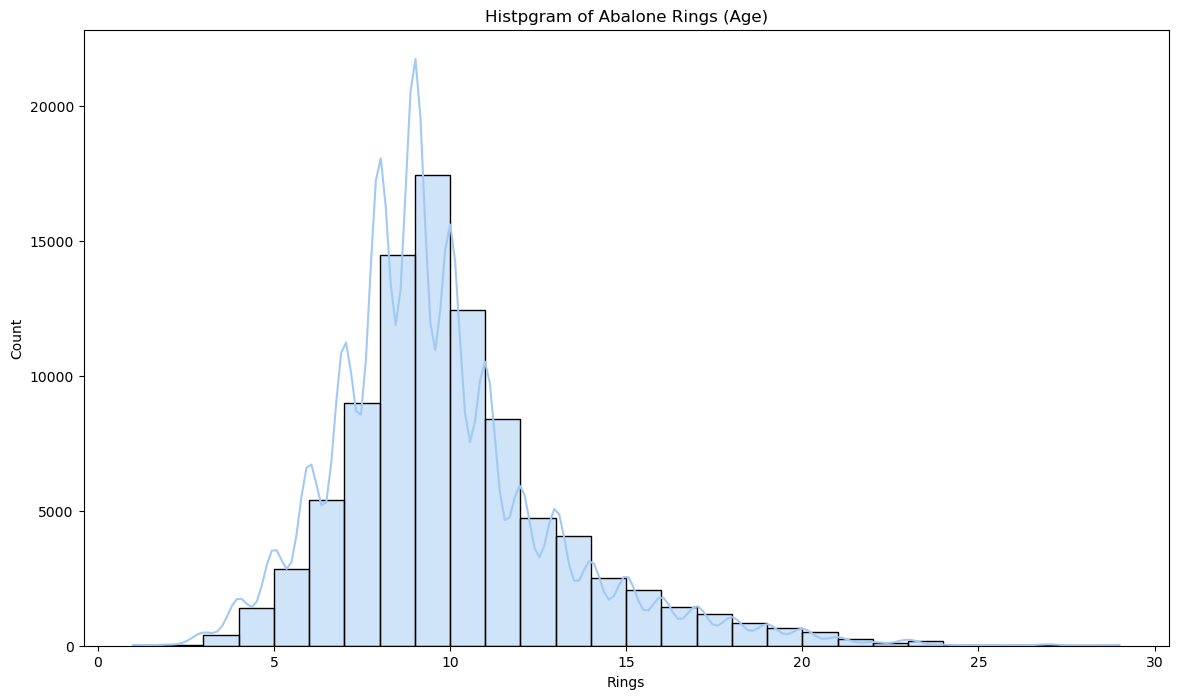

In [31]:
plt.title("Histpgram of Abalone Rings (Age)")
sns.histplot(data=df, x="Rings", binwidth=1, kde=True);

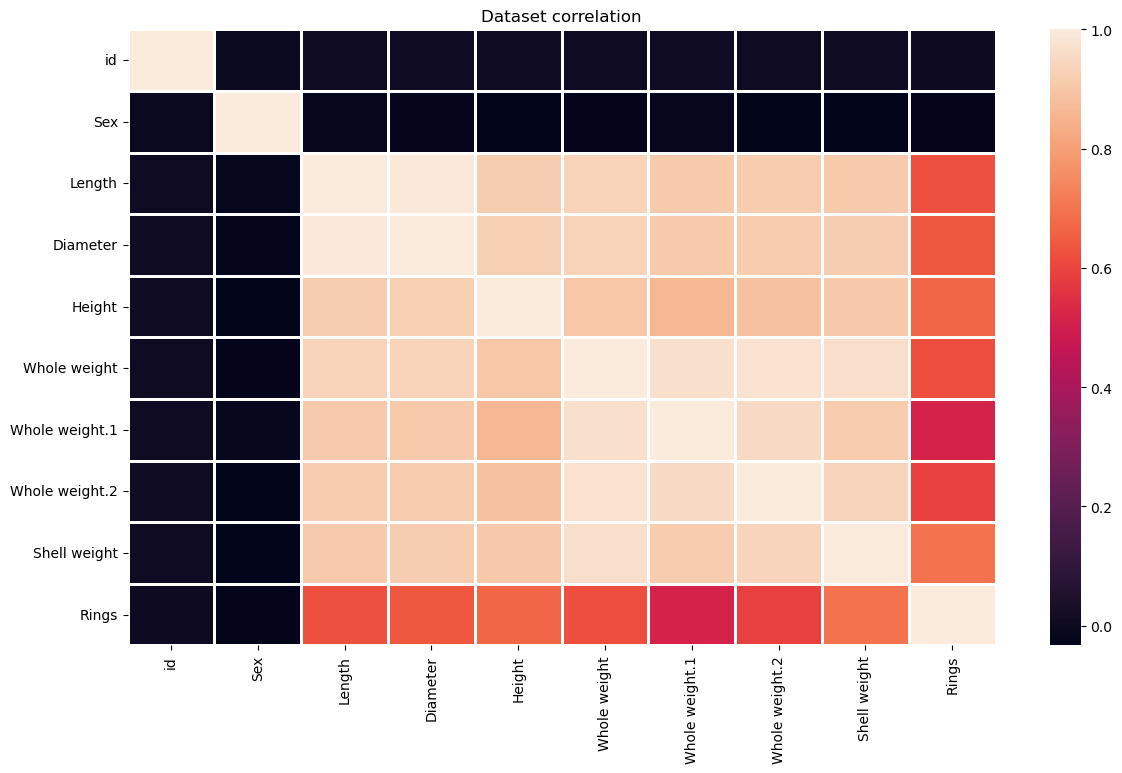

In [19]:
plt.title("Dataset correlation")
sns.heatmap(df.corr(), annot=False, fmt=".1f", linewidths=0.9);

In [37]:
def scatterplot_plot(label1, label2, hue, title):
    plt.title(title)
    sns.scatterplot(data=df, x=label1, y=label2, hue=hue)

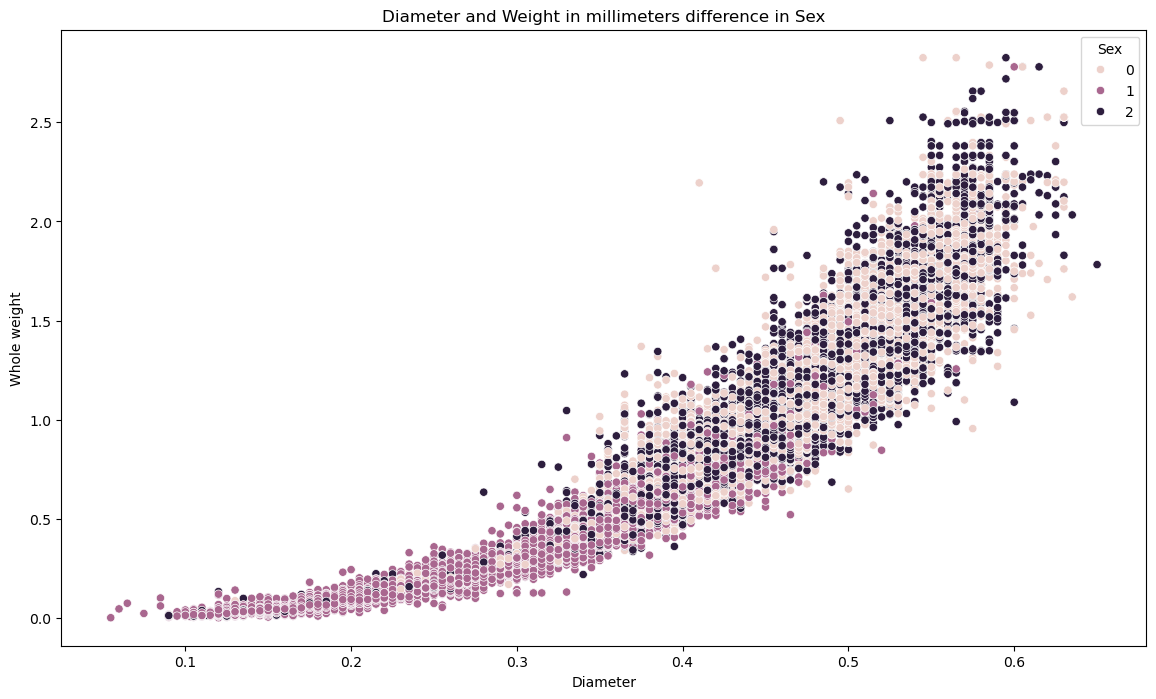

In [40]:
scatterplot_plot("Diameter", "Whole weight", "Sex", "Diameter and Weight in millimeters difference in Sex")

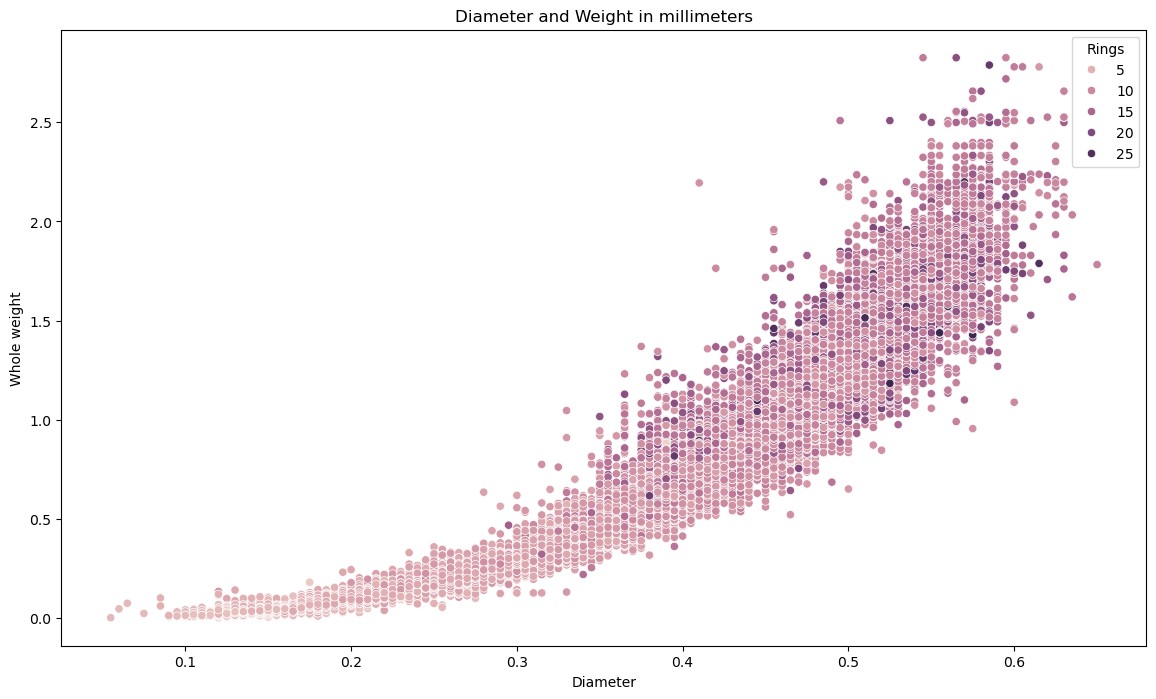

In [39]:
scatterplot_plot("Diameter", "Whole weight", "Rings", "Diameter and Weight in millimeters in Rings")